In [5]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## 1 使用一个卷积核对图像进行处理

### 注意这里打开的图片文件要和程序文件在一个目录下

In [11]:
im = Image.open('./cat.jpg').convert('L')
im = np.array(im,dtype='float32')

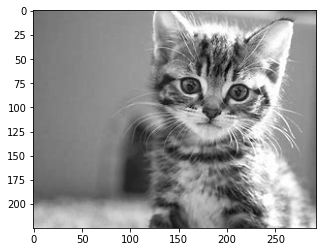

In [14]:
plt.imshow(im.astype('uint8'),cmap='gray')

In [15]:
im = torch.from_numpy(im.reshape((1,1,im.shape[0],im.shape[1])))

In [20]:
conv1 = nn.Conv2d(1,1,3,bias=False)
sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # 定义轮廓检测算子
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) # 适配卷积的输入输出
conv1.weight.data = torch.from_numpy(sobel_kernel) # 给卷积的 kernel 赋值

edge1 = conv1(Variable(im)) # 作用在图片上
edge1 = edge1.data.squeeze().numpy() # 将输出转换为图片的格式

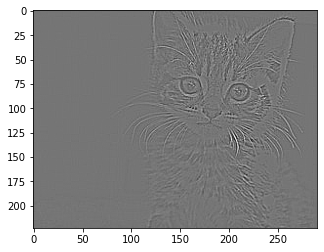

In [21]:
plt.imshow(edge1,cmap='gray')

#### 池化

In [31]:
pool1 = nn.MaxPool2d(2,2)
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im1 = pool1(Variable(im))
small_im1 = small_im1.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))

before max pool, image shape: 225 x 293
after max pool, image shape: 112 x 146 


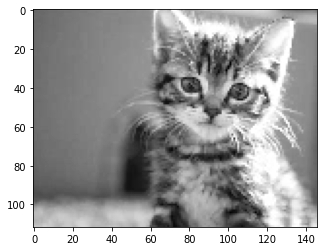

In [32]:
plt.imshow(small_im1,cmap='gray')

## 2 实现一些网络

### LeNet

In [67]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        layer1 = nn.Sequential()
        layer1.add_module('conv1',nn.Conv2d(3,6,3,padding=1))
        layer1.add_module('relu1',nn.ReLU(True))
        layer1.add_module('pool1',nn.MaxPool2d(2,2))
        self.layer1 = layer1
        
        layer2 = nn.Sequential()
        layer2.add_module('conv2',nn.Conv2d(6,6,5))
        layer2.add_module('relu2',nn.ReLU(True))
        layer2.add_module('pool2',nn.MaxPool2d(2,2))
        self.layer2 = layer2
        
        layer3 = nn.Sequential()
        layer3.add_module('fc1',nn.Linear(256,120))
        layer3.add_module('fc2',nn.Linear(120,84))
        layer3.add_module('fc3',nn.Linear(84,10))
        self.layer3 = layer3
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0),-1)
        x = self.layer3(x)
        return x
    

In [60]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import CIFAR10

In [61]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化
    x = x.transpose((2, 0, 1)) # 将 channel 放到第一维
    x = torch.from_numpy(x)
    return x
     
train_set = CIFAR10('./data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./data', train=False, transform=data_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = Lenet()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [68]:
import time
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(5):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data)) 
    eval_loss = 0
    eval_acc = 0
    net.eval()
    
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 1.198474, Train Acc: 0.588355, Eval Loss: 1.208921, Eval Acc: 0.581487
epoch: 1, Train Loss: 1.195918, Train Acc: 0.589554, Eval Loss: 1.217219, Eval Acc: 0.573081
epoch: 2, Train Loss: 1.194851, Train Acc: 0.588995, Eval Loss: 1.220898, Eval Acc: 0.571005
epoch: 3, Train Loss: 1.191398, Train Acc: 0.591652, Eval Loss: 1.202068, Eval Acc: 0.582476
epoch: 4, Train Loss: 1.191127, Train Acc: 0.590813, Eval Loss: 1.198672, Eval Acc: 0.585146


### VGG

In [83]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(64,64,3,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(128,128,3,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(256,256,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(256,256,3,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(512,512,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(512,512,3,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(512,512,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(512,512,3,padding = 1),
            nn.ReLU(True),
            nn.Conv2d(512,512,3,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            )
        self.classifier = nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,10),
            )
        #self._initialize_weights()
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
    

In [84]:
net2 = vgg()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(5):
    train_loss = 0
    train_acc = 0
    net2.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net2(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data)) 
    eval_loss = 0
    eval_acc = 0
    net2.eval()
    
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net2(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

KeyboardInterrupt: 

In [2]:
def vgg_block(num_convs,in_channels,out_channels):
    net = [nn.Conv2d(in_channels,out_channels,3,padding = 1),nn.ReLU(True)]
    
    for i in range(num_convs-1):
        net.append(nn.Conv2d(out_channels,out_channels,3,padding=1))
        net.append(nn.ReLU(True))
        
    net.append(nn.MaxPool2d(2,2))
    return nn.Sequential(*net)
#注意这里的‘*’号

In [86]:
wangzhiyong = vgg_block(3,64,128)
print(wangzhiyong)

Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [87]:
lijianhang = Variable(torch.zeros(3,64,300,300))
maqun = wangzhiyong(lijianhang)
print(maqun.shape)

torch.Size([3, 128, 150, 150])


In [3]:
def vgg_stack(num_convs,channels):
    net = []
    for n,c in zip(num_convs,channels):
        in_c = c[0]
        out_c = c[1]
        net.append(vgg_block(n,in_c,out_c))
    return nn.Sequential(*net)

In [6]:
vgg_net = vgg_stack((1,1,2,2,2),((3,64),(64,128),(128,256),(256,512),(512,512)))
print(vgg_net)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(ker

In [8]:
test1 = Variable(torch.zeros(1,3,256,256))
test2 = vgg_net(test1)
print(test2.shape)

torch.Size([1, 512, 8, 8])


In [9]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg,self).__init__()
        self.feature = vgg_net
        self.fc = nn.Sequential(
            nn.Linear(512,100),
            nn.ReLU(True),
            nn.Linear(100,10)
            )
    def forward(self,x):
        x = self.feature(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x
    

In [13]:
from torchvision.datasets import CIFAR10
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化
    x = x.transpose((2, 0, 1)) # 将 channel 放到第一维
    x = torch.from_numpy(x)
    return x
     
train_set = CIFAR10('./data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./data', train=False, transform=data_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [38]:
net3 = vgg()
optimizer = torch.optim.Adam(net3.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(5):
    train_loss = 0
    train_acc = 0
    net3.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net3(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data)) 
    eval_loss = 0
    eval_acc = 0
    net3.eval()
    
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net3(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 1.263579, Train Acc: 0.538703, Eval Loss: 1.128412, Eval Acc: 0.588113
epoch: 1, Train Loss: 1.008402, Train Acc: 0.639066, Eval Loss: 0.952803, Eval Acc: 0.663865
epoch: 2, Train Loss: 0.849747, Train Acc: 0.701387, Eval Loss: 0.949308, Eval Acc: 0.671677
epoch: 3, Train Loss: 0.723497, Train Acc: 0.749181, Eval Loss: 0.843072, Eval Acc: 0.720036
epoch: 4, Train Loss: 0.624360, Train Acc: 0.783947, Eval Loss: 0.806198, Eval Acc: 0.737441


### AlexNet

#### 利用类似的block方式定义Alex。这里添加池化层不能使用add.module。

In [23]:
def alex_block(inc,outc,ksize,std,pad,maxornot):
    net = [nn.Conv2d(inc,outc,kernel_size = ksize,stride = std,padding = pad),nn.ReLU(True)]
    if maxornot == 1:
        net.append(nn.MaxPool2d(3,2))
    return nn.Sequential(*net)
        
alex_demo = alex_block(3,64,11,4,2,1)
print(alex_demo)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [28]:
def alex_stack(channels):
    net = []
    for c in channels:
        in_c = c[0]
        out_c = c[1]
        k = c[2]
        s = c[3]
        p = c[4]
        m = c[5]
        net.append(alex_block(in_c,out_c,k,s,p,m))
    return nn.Sequential(*net)

In [30]:
alexnet = alex_stack(((3,64,11,4,2,1),(64,192,5,1,2,1),(192,384,3,1,1,0),(384,256,3,1,1,0),(256,256,3,1,1,1)))
print(alexnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [37]:
class AlexNet(nn.Module):
    def __init__(self,num_classes):
        super(AlexNet,self).__init__()
        self.wzyjuanji = alexnet
        self.wzyquanlianjie = nn.Sequential(
            nn.Linear(256,100),
            nn.ReLU(True),
            nn.Linear(100,num_classes)
            )
    def forward(self,x):
        x = self.wzyjuanji(x)
        x = x.view(x.shape[0],-1)
        x = self.wzyquanlianjie(x)
        return x
net4 = AlexNet(10)     
net4

AlexNet(
  (wzyjuanji): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (wzyquanlianjie): Sequ

### GoogleNet

In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import CIFAR10

In [2]:
def conv_relu(in_channel, out_channel, kernel, stride=1, padding=0):
    layer = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, stride, padding),
        #卷积后进行归一化处理，防止经过relu激活函数时因为数据过大而导致性能不稳定
        nn.BatchNorm2d(out_channel, eps=1e-3),
        nn.ReLU(True)
    )
    return layer

In [3]:
#下面定义inception结构。根据示意图可以逐步写出四个分线路的结构。
#每一个线路的输入相同，因此size都是一样的
class inception(nn.Module):
    def __init__(self,in_channel,out1_1,out2_1,out2_2,out3_1,out3_5,out4_1):
        super(inception,self).__init__()
        # the first path
        self.branch1x1 = conv_relu(in_channel,out1_1,1)
        #the second one
        self.branch3x3 = nn.Sequential(
            conv_relu(in_channel,out2_1,1),
            conv_relu(out2_1,out2_2,3,padding = 1)
            )
        # the third one
        self.branch5x5 = nn.Sequential(
            conv_relu(in_channel,out3_1,1),
            conv_relu(out3_1,out3_5,5,padding = 2)
            )
        #t the forth one
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3,stride=1,padding=1),
            conv_relu(in_channel,out4_1,1)
            )
    def forward(self,x):
        f1 = self.branch1x1(x)
        f2 = self.branch3x3(x)
        f3 = self.branch5x5(x)
        f4 = self.branch_pool(x)
        # 对四个输出在深度上进行拼接，得到最后的结果
        # 输出通道数为out1_1+out2_2+out3_5+out4_1
        output = torch.cat((f1,f2,f3,f4),dim=1)
        return output
    

In [4]:
wangzhiyong = inception(3,64,48,64,64,96,32)
maqun = Variable(torch.zeros(1,3,96,96))
print('input shape:{}x{}x{}'.format(maqun.shape[1],maqun.shape[2],maqun.shape[3]))
lijianhang = wangzhiyong(maqun)
print('output shape:{}x{}x{}'.format(lijianhang.shape[1],lijianhang.shape[2],lijianhang.shape[3]))
# 可以看见输出通道数确实为四个分线路的通道之和（64+64+96+32=256）

input shape:3x96x96
output shape:256x96x96


In [19]:
# 有了inception模块，随后即可定义GoogleNet。
class googlenet(nn.Module):
    def __init__(self,in_channel,num_classes,verbose):
        super(googlenet,self).__init__()
        self.verbose = verbose
        self.block1 = nn.Sequential(
            conv_relu(in_channel,64,7,stride = 2,padding = 3),
            nn.MaxPool2d(3,2)
            )
        self.block2 = nn.Sequential(
            conv_relu(64,64,1),
            conv_relu(64,192,3,padding=1),
            nn.MaxPool2d(3, 2)
            )
        self.block3 = nn.Sequential(
            inception(192,64,96,128,16,32,32),
            inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2)
            )
        self.block4 = nn.Sequential(
            inception(480, 192, 96, 208, 16, 48, 64),
            inception(512, 160, 112, 224, 24, 64, 64),
            inception(512, 128, 128, 256, 24, 64, 64),
            inception(512, 112, 144, 288, 32, 64, 64),
            inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2)
        )
        self.block5 = nn.Sequential(
            inception(832, 256, 160, 320, 32, 128, 128),
            inception(832, 384, 182, 384, 48, 128, 128),
            nn.AvgPool2d(2)
        )
        self.classifier = nn.Linear(1024,num_classes)
    def forward(self,x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x
    

In [20]:
minhui = googlenet(3,10,True)
lijianhang = Variable(torch.zeros(1,3,96,96))
maqun = minhui(lijianhang)
print('output:{}'.format(maqun.shape))

block 1 output: torch.Size([1, 64, 23, 23])
block 2 output: torch.Size([1, 192, 11, 11])
block 3 output: torch.Size([1, 480, 5, 5])
block 4 output: torch.Size([1, 832, 2, 2])
block 5 output: torch.Size([1, 1024, 1, 1])
output:torch.Size([1, 10])


In [22]:
def data_tf(x):
    x = x.resize((96, 96), 2) # 将图片放大到 96 x 96
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化
    x = x.transpose((2, 0, 1)) # 将 channel 放到第一维， pytorch 要求的输入方式
    x = torch.from_numpy(x)
    return x
     
train_set = CIFAR10('./data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./data', train=False, transform=data_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

minhuipro = googlenet(3, 10,False)
optimizer = torch.optim.Adam(minhuipro.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(5):
    train_loss = 0
    train_acc = 0
    minhuipro.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = minhuipro(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data)) 
    eval_loss = 0
    eval_acc = 0
    minhuipro.eval()
    
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = minhuipro(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 1.807152, Train Acc: 0.315257, Eval Loss: 1.538058, Eval Acc: 0.430775
epoch: 1, Train Loss: 1.237310, Train Acc: 0.547035, Eval Loss: 1.042793, Eval Acc: 0.625396
epoch: 2, Train Loss: 0.963409, Train Acc: 0.661165, Eval Loss: 0.957921, Eval Acc: 0.666831
epoch: 3, Train Loss: 0.789864, Train Acc: 0.724405, Eval Loss: 0.934932, Eval Acc: 0.682061
epoch: 4, Train Loss: 0.672817, Train Acc: 0.768143, Eval Loss: 0.699928, Eval Acc: 0.756230


### ResNet

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10

In [10]:
def conv3x3(in_channel,out_channel,stride = 1):
    return nn.Conv2d(in_channel,out_channel,3,stride=stride,padding=1,bias=False)
class res_block(nn.Module):
    def __init__(self,in_channel,out_channel,same_shape=True):
        super(res_block,self).__init__()
        self.same_shape = same_shape
        stride = 1 if self.same_shape else 2
        self.conv1 = conv3x3(in_channel,out_channel,stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = conv3x3(out_channel,out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        if not self.same_shape:
            self.conv3 = nn.Conv2d(in_channel,out_channel,1,stride=stride)
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out),True)
        out = self.conv2(out)
        out = F.relu(self.bn2(out),True)
        
        if not self.same_shape:#如果大小不一致的话就通过第三个卷积层使x、out一致。
            x = self.conv3(x)
        return F.relu(x+out, True)

In [11]:
test_net = res_block(32, 32)
test_x = Variable(torch.zeros(1, 32, 96, 96))
print('input: {}'.format(test_x.shape))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

input: torch.Size([1, 32, 96, 96])
output: torch.Size([1, 32, 96, 96])


In [12]:
test_net = res_block(3, 32, False)
test_x = Variable(torch.zeros(1, 3, 96, 96))
print('input: {}'.format(test_x.shape))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

input: torch.Size([1, 3, 96, 96])
output: torch.Size([1, 32, 48, 48])


In [13]:
class resnet(nn.Module):
    def __init__(self,in_channel,num_classes,verbose=False):
        super(resnet,self).__init__()
        self.verbose = verbose
        self.block1 = nn.Conv2d(in_channel,64,7,2)
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3,2),
            res_block(64,64),
            res_block(64,64)
            )
        self.block3 = nn.Sequential(
            res_block(64,128,False),
            res_block(128,128)
            )
        self.block4 = nn.Sequential(
            res_block(128,256,False),
            res_block(256,256)
            )
        self.block5 = nn.Sequential(
            res_block(256,512,False),
            res_block(512,512),
            nn.AvgPool2d(3)
            )
        self.classifier = nn.Linear(512,num_classes)
    def forward(self,x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [14]:
test_net = resnet(3, 10, True)
test_x = Variable(torch.zeros(1, 3, 96, 96))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

block 1 output: torch.Size([1, 64, 45, 45])
block 2 output: torch.Size([1, 64, 22, 22])
block 3 output: torch.Size([1, 128, 11, 11])
block 4 output: torch.Size([1, 256, 6, 6])
block 5 output: torch.Size([1, 512, 1, 1])
output: torch.Size([1, 10])


In [18]:
tensor1 = torch.tensor([[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]])
tensor1.shape

torch.Size([2, 3, 3])

In [19]:
tensor2 = torch.tensor([[[2,2,2],[2,2,2],[2,2,2]],[[1,1,1],[1,1,1],[1,1,1]]])
tensor2.shape

torch.Size([2, 3, 3])

In [22]:
inp = [tensor1,tensor2]
tensor3 = torch.cat(inp,dim=0)
tensor3.shape

torch.Size([4, 3, 3])

### 注意以下两种数据类型的错误
---

In [25]:
torch.tensor(inp).shape

ValueError: only one element tensors can be converted to Python scalars

In [26]:
inp.shape

AttributeError: 'list' object has no attribute 'shape'

---

In [29]:
tensor4 = torch.cat(inp,dim=1)
print(tensor4.shape)
tensor5 = torch.cat(inp,dim=2)
print(tensor5.shape)
# cat函数对tensor在不同维度上进行拼接。

torch.Size([2, 6, 3])
torch.Size([2, 3, 6])


### DenseNet

In [30]:
def conv_block(in_channel,out_channel):
    layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(True),
        nn.Conv2d(in_channel,out_channel,3,padding=1,bias=False)
        )
    return layer

In [31]:
class dense_block(nn.Module):
    def __init__(self,in_channel,growth_rate,num_layers):
        super(dense_block,self).__init__()
        block=[]
        channel = in_channel
        for i in range(num_layers):
            block.append(conv_block(channel,growth_rate))
            channel += growth_rate
        self.net = nn.Sequential(*block)
    def forward(self,x):
        for layer in self.net:
            out = layer(x)
            x = torch.cat((out,x),dim=1)
        return x

In [32]:
test_net = dense_block(3, 12, 3)
test_x = Variable(torch.zeros(1, 3, 96, 96))# 经过12次运算叠加后，结果的维度应为39
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 39 x 96 x 96


In [33]:
def transition(in_channel,out_channel):
    trans_layer = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.ReLU(True),
        nn.Conv2d(in_channel,out_channel,1),
        nn.AvgPool2d(2,2)
        )
    return trans_layer


In [35]:
wangzhiyong = transition(3,12)
wangzhiyongpro = Variable(torch.zeros(1,3,96,96))
print('input shape: {} x {} x {}'.format(wangzhiyongpro.shape[1],wangzhiyongpro.shape[2],wangzhiyongpro.shape[3]))
wzy = wangzhiyong(test_x)
print('output shape: {} x {} x {}'.format(wzy.shape[1],wzy.shape[2],wzy.shape[3]))

input shape: 3 x 96 x 96
output shape: 12 x 48 x 48


In [36]:
class densenet(nn.Module):
    def __init__(self,in_channel,num_classes,growth_rate=32,block_layers=[6,12,34,16]):
        super(densenet,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channel,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(3,2,padding=1)
            )
        channels = 64
        block = []
        for i,layers in enumerate(block_layers):
            block.append(dense_block(channels,growth_rate,layers))
            channels += layers*growth_rate
            if i != len(block_layers) - 1:
                block.append(transition(channels,channels//2))
                channels = channels//2
        
        self.block2 = nn.Sequential(*block)
        self.block2.add_module('bn',nn.BatchNorm2d(channels))
        self.block2.add_module('relu',nn.ReLU(True))
        self.block2.add_module('avg',nn.AvgPool2d(3))
        
        self.classifier = nn.Linear(channels,num_classes)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x

In [37]:
wzy = densenet(3, 10)
lijianhang = Variable(torch.zeros(1, 3, 96, 96))
maqun = wzy(lijianhang)
print('output: {}'.format(maqun.shape))

output: torch.Size([1, 10])


### 自行测试

In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import mnist

## 这里注意要将原二维矩阵扩至三维，否则送入网络中计算时会类型不匹配

In [4]:
def data_tf(x):
    x = np.array(x,dtype='float32')/255
    x = (x-0.5)/0.5
    x = np.reshape(x,(1,28,28))
    x = torch.from_numpy(x)
    return x
train_set = mnist.MNIST('./data',train=True,transform=data_tf)
test_set = mnist.MNIST('./data',train=False,transform=data_tf)

In [5]:
a,a_label = train_set[0]
b = Variable(a)
print(a.shape)
print(b.shape)
print(a_label)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
5


In [6]:
from torch.utils.data import DataLoader
train_data = DataLoader(train_set,batch_size=64,shuffle=True)
test_data = DataLoader(test_set,batch_size=128,shuffle=False)

In [7]:
class maqun(nn.Module):
    def __init__(self):
        super(maqun,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,3),#26*26*16
            nn.BatchNorm2d(16),
            nn.ReLU(True)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1,stride=1),#26*26*32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1,stride=1),#13*13*64
            nn.BatchNorm2d(64),
            nn.ReLU(True)
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64,128,4),#10*10*128
            nn.BatchNorm2d(128),
            nn.ReLU(True)
            )
        self.classifier = nn.Sequential(
            nn.Linear(12800,1024),
            nn.ReLU(True),
            nn.Linear(1024,128),
            nn.ReLU(True),
            nn.Linear(128,10)
            )
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
    

In [8]:
maqunnet = maqun()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(maqunnet.parameters(),lr = 1e-2, weight_decay = 1e-4)

In [ ]:
losses = []
acces = []
eval_losses = []
eval_acces = []
for e in range(20):
    train_loss = 0
    train_acc = 0
    maqunnet.train()#开始训练模型
    for im,label in train_data:
        im = Variable(im)
        label = Variable(label)
        #前向传播
        out = maqunnet(im)
        loss = criterion(out,label)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #用下划线来表示不关心的类别
        train_loss += loss.item()
        _, pred = out.max(1)#给出一张图片对应每种类别的概率的最大值的索引，即为该张图片所属的类别
        #计算正确率
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data)) 
    eval_loss = 0
    eval_acc = 0
    maqunnet.eval() #开始测试模型
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = maqunnet(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.088957, Train Acc: 0.976862, Eval Loss: 0.051880, Eval Acc: 0.984771
epoch: 1, Train Loss: 0.073973, Train Acc: 0.978978, Eval Loss: 0.050126, Eval Acc: 0.985957
epoch: 2, Train Loss: 0.065608, Train Acc: 0.980777, Eval Loss: 0.047661, Eval Acc: 0.985759
epoch: 3, Train Loss: 0.059364, Train Acc: 0.982476, Eval Loss: 0.038545, Eval Acc: 0.988825


---
---
## 以上由于一些设备问题未能跑完，后边争取在谷歌云盘上嫖gpu跑~

In [2]:
import torch
print(torch.__version__)

1.11.0+cpu
